# Trend Classification with LSTM

### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'

# 1.0 Load data

In [3]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [4]:
traditional_energy_stocks = [
    "LNG",
    "OKE",
    "BKR",
    "WMB",
    "EQT", 
    "XEC", 
    "XOM", 
    "CVX", 
    "BP", 
    "OXY", 
    "COP", 
    "EOG", 
    "COG", 
    "CNQ", 
    "SLB", 
    "PTR", 
    "TOT", 
    "ENB",  
]

In [5]:
data = get_data_yf(traditional_energy_stocks, time_period)

[*********************100%***********************]  18 of 18 completed


In [6]:
data.isna().sum().sum()

0

In [7]:
data = process_stock_data_from_yf(data)

In [8]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

In [9]:
### Compute technical indicators

In [10]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

In [11]:
### Load climate trends data

In [12]:
filenames = [os.path.join("data", x) for x in [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
] ]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [13]:
climate_trends_data = load_climate_data(filenames, terms)

In [14]:
climate_trends_data.shape

(2278, 11)

In [15]:
num_climate_features = len(climate_trends_data.columns.tolist()) - 1 # minus date

<AxesSubplot:xlabel='Date'>

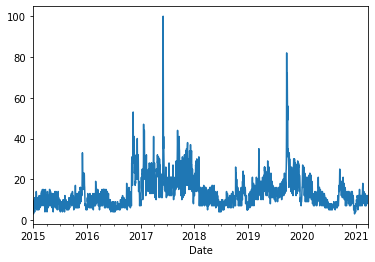

In [16]:
climate_trends_data.set_index('Date')['climate change'].plot()

# 2.0 Prepare dataset of many stocks

### Choose technical features

In [17]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Train test split

In [18]:
train = dataset.loc[dataset['Date'] < "2018-03-01"]
valid = dataset.loc[(dataset['Date'] > "2018-03-13") & (dataset['Date'] < "2019-03-01")]
test = dataset.loc[(dataset['Date'] > "2019-03-01") & (dataset['Date'] < "2020-03-01")]

In [19]:
train.shape

(13230, 31)

In [20]:
test.shape

(4518, 31)

#### Per stock normalization
We make sure to fit the transforms on the training, and
apply them on training, validation, and test

In [21]:
scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

### Merge in the climate data

In [22]:
train = train.merge(climate_trends_data, on=["Date"], how='left')
valid = valid.merge(climate_trends_data, on=["Date"], how='left')
test = test.merge(climate_trends_data, on=["Date"], how='left')

#### Prepare training inputs and outputs
Convert the daily data points into a set of data points each with {trail_size} days.   
We keep track of the tickers so we can later inverse the normalization with the right model. 

In [23]:
x_train, y_train, tickers_train = roll_all_stocks(train, trail_size, predict_length, trend_classify=True)
x_valid, y_valid, tickers_valid = roll_all_stocks(valid, trail_size, predict_length, trend_classify=True)
x_test, y_test, tickers_test = roll_all_stocks(test, trail_size, predict_length, trend_classify=True)

In [24]:
num_features+=num_climate_features

In [25]:
#### Confirm shapes

In [26]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (12654, 14, 39)
y_train: (12654,)
x_valid: (4032, 14, 39)
y_valid (4032,)
x_test: (4180, 14, 39)
y_test (4180,)


In [27]:
np.mean(y_train)

0.4973131025762605

In [28]:
np.mean(y_valid)

0.5277777777777778

In [29]:
np.mean(y_test)

0.47033492822966505

### Model design

In [30]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            34500     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [32]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [34]:
history1 = model.fit(x_train, 
                     y_train, 
                     epochs=30, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/30
198/198 [==============================] - 9s 22ms/step - loss: 0.6835 - accuracy: 0.5476 - val_loss: 0.6911 - val_accuracy: 0.5412
Epoch 2/30
198/198 [==============================] - 2s 10ms/step - loss: 0.6664 - accuracy: 0.5903 - val_loss: 0.7007 - val_accuracy: 0.5496
Epoch 3/30
198/198 [==============================] - 2s 11ms/step - loss: 0.6517 - accuracy: 0.6136 - val_loss: 0.7506 - val_accuracy: 0.5255
Epoch 4/30
198/198 [==============================] - 2s 11ms/step - loss: 0.6432 - accuracy: 0.6238 - val_loss: 0.7201 - val_accuracy: 0.5464
Epoch 5/30
198/198 [==============================] - 2s 11ms/step - loss: 0.6265 - accuracy: 0.6502 - val_loss: 0.7116 - val_accuracy: 0.5640
Epoch 6/30
198/198 [==============================] - 2s 11ms/step - loss: 0.6114 - accuracy: 0.6665 - val_loss: 0.7110 - val_accuracy: 0.5506
Epoch 7/30
198/198 [==============================] - 2s 11ms/step - loss: 0.6061 - accuracy: 0.6628 - val_loss: 0.7224 - val_accuracy: 0.5565

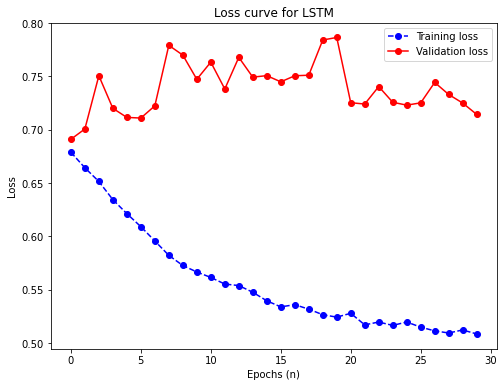

In [35]:
plot_loss(history1)

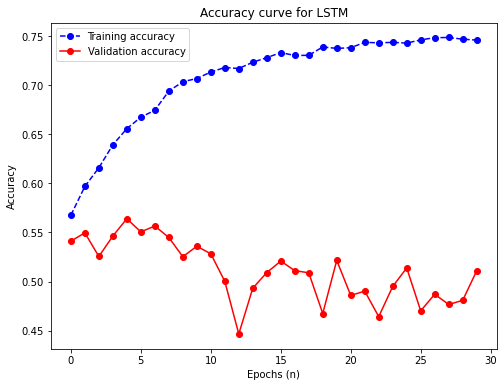

In [36]:
plot_acc(history1)

#### Performance of model

In [37]:
performance_stats(model, x_train, y_train)

Upward ratio: 0.4973131025762605
Mean prediction: 0.5072978734970093
Predicted upward ratio: 0.510273431326063
Accuracy: 0.7640271850798167


In [38]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 0.5277777777777778
Mean prediction: 0.5527334213256836
Predicted upward ratio: 0.7361111111111112
Accuracy: 0.5109126984126984


In [39]:
performance_stats(model, x_test, y_test)

Upward ratio: 0.47033492822966505
Mean prediction: 0.5433936715126038
Predicted upward ratio: 0.5593301435406699
Accuracy: 0.49569377990430624


# 3.0 Prepare data for one stock

In [40]:
all_stock_features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']

In [41]:
x_train2, y_train2, x_valid2, y_valid2, x_test2, y_test2 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           ["LNG"],
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           all_stock_features, terms,
                                                                            trail_size, predict_length
                                                                           )

In [42]:
print("x_train: {}".format(x_train2.shape))
print("y_train: {}".format(y_train2.shape))
print("x_valid: {}".format(x_valid2.shape))
print("y_valid {}".format(y_valid2.shape))
print("x_test: {}".format(x_test2.shape))
print("y_test {}".format(y_test2.shape))

x_train: (703, 14, 39)
y_train: (703,)
x_valid: (232, 14, 39)
y_valid (232,)
x_test: (233, 14, 39)
y_test (233,)


In [72]:
target_stock = 'LNG'

In [73]:
single_stock_dataset = dataset[dataset['Ticker']==target_stock].reset_index(drop=True)

<AxesSubplot:xlabel='Date', ylabel='Close'>

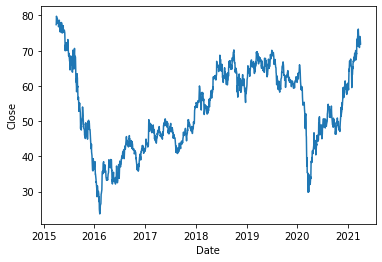

In [74]:
sns.lineplot(x=single_stock_dataset['Date'], y=single_stock_dataset['Close'])

In [75]:
train = single_stock_dataset.loc[single_stock_dataset['Date'] < "2018-03-01"]
valid = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2018-03-01") & (single_stock_dataset['Date'] < "2019-03-01")]
test = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2019-03-01") & (single_stock_dataset['Date'] < "2020-03-01")]

In [76]:
single_stock_scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

In [77]:
climate_trends_data[terms[:3]+['Date']]

Term,climate change,greenhouse gas,oil,Date
0,4.0,20.0,27.0,2015-01-01
1,3.0,47.0,34.0,2015-01-02
2,5.0,25.0,34.0,2015-01-03
3,5.0,36.0,32.0,2015-01-04
4,9.0,26.0,39.0,2015-01-05
...,...,...,...,...
2273,11.0,19.0,32.0,2021-03-23
2274,12.0,22.0,34.0,2021-03-24
2275,12.0,19.0,33.0,2021-03-25
2276,11.0,17.0,34.0,2021-03-26


In [78]:
train = train.merge(climate_trends_data[terms+['Date']], on=["Date"], how='left')
valid = valid.merge(climate_trends_data[terms+['Date']], on=["Date"], how='left')
test = test.merge(climate_trends_data[terms+['Date']], on=["Date"], how='left')

In [79]:
test

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI,climate change,greenhouse gas,oil,renewable,carbon tax,electric vehicles,environmental protection agency,fossil fuels,fracking,global warming
0,LNG,2019-03-04,0.736683,0.753992,0.739587,0.770521,0.316441,0.730108,0.734562,0.149023,0.742561,0.181756,0.236364,0.354052,0.655214,0.751565,0.735022,0.752534,0.726229,0.756662,0.153006,0.153006,0.752170,0.491046,0.001515,0.630781,0.771522,4561.549418,0.316337,0.686072,0.306381,16.0,27.0,40.0,49.0,10.0,74.0,0.0,47.0,0.0,18.0
1,LNG,2019-03-05,0.763941,0.745920,0.754895,0.742983,0.096057,0.730108,0.734562,0.165179,0.743538,0.193518,0.923077,0.374092,0.339877,0.663883,0.738838,0.751389,0.729150,0.755861,0.144721,0.144721,0.751754,0.599123,0.046471,0.307042,0.652818,4561.588570,0.337489,0.701543,0.319647,20.0,16.0,41.0,54.0,9.0,63.0,0.0,54.0,0.0,15.0
2,LNG,2019-03-06,0.746660,0.749254,0.756675,0.765225,0.058433,0.730108,0.734562,0.170097,0.743139,0.191561,0.164473,0.383096,0.419632,0.584551,0.739651,0.750116,0.728419,0.755776,0.146012,0.146012,0.751046,0.521016,0.004371,0.386819,0.550964,4561.586342,0.317395,0.702050,0.337403,20.0,20.0,41.0,58.0,14.0,58.0,0.0,38.0,0.0,17.0
3,LNG,2019-03-07,0.768039,0.754167,0.752937,0.746867,0.069175,0.730108,0.734562,0.179748,0.744185,0.206080,0.825872,0.412431,0.430674,0.552192,0.743442,0.748600,0.731859,0.754641,0.136681,0.136681,0.750169,0.598621,0.098576,0.396492,0.511023,4561.668675,0.338453,0.716299,0.331165,17.0,23.0,41.0,51.0,15.0,51.0,0.0,37.0,0.0,18.0
4,LNG,2019-03-08,0.759665,0.743639,0.747419,0.733274,0.054689,0.730108,0.734562,0.179389,0.744281,0.207176,0.872092,0.447865,0.322699,0.541754,0.745518,0.746536,0.732137,0.754571,0.136022,0.136022,0.749203,0.560879,0.004488,0.296474,0.500010,4561.669670,0.324619,0.721634,0.285862,16.0,20.0,39.0,45.0,10.0,31.0,0.0,29.0,0.0,15.0
5,LNG,2019-03-11,0.790130,0.771363,0.768957,0.760459,0.109137,0.742744,0.734562,0.199996,0.745782,0.244667,0.956939,0.447575,0.590183,0.700417,0.751715,0.742917,0.739776,0.750531,0.116300,0.116300,0.748194,0.661085,0.001868,0.540783,0.685078,4561.260392,0.344769,0.745668,0.395000,20.0,20.0,42.0,49.0,11.0,57.0,0.0,36.0,0.0,18.0
6,LNG,2019-03-12,0.818457,0.800316,0.809363,0.804060,0.104449,0.775321,0.734562,0.218234,0.750778,0.350817,0.897958,0.465582,0.598773,0.811064,0.761175,0.742372,0.762182,0.739783,0.080773,0.080773,0.747568,0.736822,0.002227,0.544639,0.808183,4561.177728,0.396018,0.783141,0.465446,20.0,9.0,39.0,49.0,5.0,55.0,0.0,35.0,0.0,16.0
7,LNG,2019-03-13,0.813469,0.815406,0.823247,0.823477,0.070191,0.792300,0.734562,0.224472,0.756214,0.413028,0.167739,0.475457,0.501840,0.655533,0.768654,0.744070,0.777910,0.735798,0.067771,0.067771,0.747366,0.712965,0.000687,0.456903,0.629584,4561.177689,0.403163,0.808861,0.466837,19.0,18.0,40.0,46.0,5.0,38.0,0.0,35.0,0.0,17.0
8,LNG,2019-03-14,0.811331,0.803474,0.821111,0.822065,0.034968,0.792300,0.734562,0.223095,0.761706,0.452749,0.262629,0.469648,0.312883,0.561586,0.774826,0.746900,0.790044,0.735117,0.061293,0.061293,0.747740,0.702316,0.009857,0.289490,0.523516,4561.184637,0.404171,0.826767,0.416551,26.0,21.0,38.0,48.0,11.0,39.0,0.0,33.0,0.0,20.0
9,LNG,2019-03-15,0.805986,0.791718,0.806159,0.808473,0.044930,0.792300,0.734562,0.196990,0.767569,0.464337,0.689656,0.444961,0.314111,0.486430,0.779404,0.751952,0.797995,0.738849,0.059851,0.059851,0.748816,0.674716,0.001585,0.288363,0.435132,4561.176089,0.410411,0.836059,0.361714,35.0,8.0,40.0,35.0,6.0,61.0,0.0,29.0,0.0,18.0


#### Prepare training inputs and outputs

In [80]:
x_train, y_train, _ = roll_all_stocks(train, trail_size, predict_length, trend_classify=True)
x_valid, y_valid, _ = roll_all_stocks(valid, trail_size, predict_length, trend_classify=True)
x_test, y_test, _ = roll_all_stocks(test, trail_size, predict_length, trend_classify=True)

In [81]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (703, 14, 39)
y_train: (703,)
x_valid: (232, 14, 39)
y_valid (232,)
x_test: (233, 14, 39)
y_test (233,)


In [82]:
x_train2[:, :, 0].min()

0.0

In [83]:
np.sum(x_train)

1978328.9223016913

In [84]:
np.sum(x_train)

1978328.9223016913

In [85]:
np.sum(x_train2)

1978328.9223016913

In [86]:
np.mean(x_valid)

4.970219586854745

In [87]:
np.mean(x_valid2)

4.970219586854745

In [88]:
np.mean(x_test)

7.653096643740877

In [89]:
np.mean(x_test2)

7.653096643740877

In [61]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train model on single stock

In [63]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [64]:
history2 = model.fit(x_train, 
                     y_train, 
                     epochs=20, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/20


ValueError: in user code:

    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\keras\engine\training.py:839 train_function  *
        return step_function(self, iterator)
    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\keras\engine\training.py:829 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1262 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2734 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3423 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\keras\engine\training.py:822 run_step  **
        outputs = model.train_step(data)
    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\keras\engine\training.py:788 train_step
        y_pred = self(x, training=True)
    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1018 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, None, 39), found shape=(None, 14, 32)


In [ ]:
plot_loss(history2)

In [ ]:
plot_acc(history2)

#### Model performance

In [ ]:
performance_stats(model, x_train, y_train)

In [ ]:
performance_stats(model, x_valid, y_valid)

In [ ]:
performance_stats(model, x_test, y_test)